In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .config("spark.driver.memory", "16g")\
    .getOrCreate()

spark

In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.sql.functions import col, lit

from common import *

plt.rc('axes', labelsize=18, titlesize=18)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=15)

In [ ]:
def get_index(prefix):
    client_sdf = spark.read.csv(f"{prefix}/*/client/0/metadata.csv", header=True)\
        .withColumn(
            "prefix",
            ancestor_udf(F.input_file_name(), lit(3))
        )

    server_sdf = spark.read.csv(f"{prefix}/*/server/0-0/metadata.csv", header=True)\
        .withColumn(
            "prefix",
            ancestor_udf(F.input_file_name(), lit(3))
        )

    return server_sdf.join(client_sdf, on='prefix')\
        .withColumn("duration", col("duration").cast(T.IntegerType()))\
        .withColumn("txns", col("txns").cast(T.IntegerType()))\
        .withColumn("clients", col("clients").cast(T.IntegerType()))\
        .withColumn("rate", col("rate").cast(T.IntegerType()))\
        .withColumn("jitter", F.regexp_extract("prefix", r"jitter(\d+)", 1))

In [ ]:
PREFIX = "main/ycsb-jitter"

IGNORE_CACHE = False

index_sdf = get_index(PREFIX)\
    .withColumn("config_name", F.regexp_replace("config_name", "\.conf", ""))

index_df = from_cache_or_compute(
    f'{PREFIX}/index.parquet',
    lambda: index_sdf\
        .toPandas()\
        .convert_dtypes()\
        .astype({
            "wl:hot": "int32",
            "wl:mh": "int32",
            "wl:mp": "int32",
        }),
    ignore_cache=IGNORE_CACHE,
)

index_df

In [ ]:
PREFIX_OVERSHOOT10 = "main/ycsb-jitter-overshoot10"

IGNORE_CACHE = False

index_overshoot10_sdf = get_index(PREFIX_OVERSHOOT10)\
    .withColumn("config_name", F.regexp_replace("config_name", "\.conf", ""))

index_overshoot10_df = from_cache_or_compute(
    f'{PREFIX_OVERSHOOT10}/index.parquet',
    lambda: index_overshoot10_sdf\
        .toPandas()\
        .convert_dtypes()\
        .astype({
            "wl:hot": "int32",
            "wl:mh": "int32",
            "wl:mp": "int32",
        }),
    ignore_cache=IGNORE_CACHE,
)

index_overshoot10_df

# Throughput

In [ ]:
IGNORE_CACHE = False

def compute_throughput(prefix):
    res = throughput(
        spark,
        prefix,
        start_offset_sec=5,
        duration_sec=50
    ).first().throughput
    print(prefix, res)
    return res

    
def compute_all_throughputs(index_sdf):
    # Extract all prefixes in the index
    throughput_df = index_sdf.select("prefix").toPandas()
    # Compute the throughput of each prefix
    throughput_df["throughput"] = throughput_df.apply(lambda r : compute_throughput(r["prefix"]), axis=1)
    # Associate metadata from the index to the throughputs
    return throughput_df.merge(index_sdf.toPandas(), on="prefix")


throughput_df = from_cache_or_compute(
    f'{PREFIX}/throughput.parquet',
    lambda: compute_all_throughputs(get_index(PREFIX).where(col("clients") == 3000))\
        .sort_values("jitter", key=lambda k: k.astype("int")),
    ignore_cache=IGNORE_CACHE,
)
throughput_df["throughput"] /= 1000

throughput_overshoot10_df = from_cache_or_compute(
    f'{PREFIX_OVERSHOOT10}/throughput.parquet',
    lambda: compute_all_throughputs(get_index(PREFIX_OVERSHOOT10).where(col("clients") == 3000))\
        .sort_values("jitter", key=lambda k: k.astype("int")),
    ignore_cache=IGNORE_CACHE,
)
throughput_overshoot10_df["throughput"] /= 1000

# Deadlocks

In [ ]:
def get_deadlocks(thrp_df):
    deadlocks_df = thrp_df[["prefix", "jitter"]].copy()
    deadlocks_df["deadlock_cnt"] = 0
    deadlocks_df["deadlock_sz"] = 0

    for i, row in deadlocks_df.iterrows():
        sdf = deadlocks_csv(spark, row.prefix).where(col("replica") == 0)
        deadlocks_df.at[i, "deadlock_cnt"] = sdf.count()
        deadlocks_df.at[i, "deadlock_sz"] = sdf.agg({"vertices": "sum"}).collect()[0][0]

    return deadlocks_df

In [ ]:
IGNORE_CACHE = False

deadlocks_df = from_cache_or_compute(
    f'{PREFIX}/deadlocks.parquet',
    lambda: get_deadlocks(throughput_df),
    ignore_cache=IGNORE_CACHE,
)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
deadlocks_df["deadlock_sz"] /= 1000
deadlocks_df.plot.bar(x="jitter", y="deadlock_sz", rot=0, ax=ax, legend=True, fill=False, hatch='/', label='size')
ax.legend(loc="upper left")
ax.set_xlabel("jitter (ms)")
ax.set_ylabel("total size (thousands)")
ax.set_ylim([0, 300])
ax.grid(axis='y')

ax2 = ax.twinx()
deadlocks_df.plot(x="jitter", y="deadlock_cnt", rot=0, ax=ax2, marker='.', color='red', label='count')
ax2.legend(loc="upper left", bbox_to_anchor=(0, 0.88))
ax2.set_ylabel("count")
ax2.set_ylim([0, 1400])

fig.tight_layout()
fig.savefig('output/jitter-deadlocks.pdf')


In [ ]:
IGNORE_CACHE=False

deadlocks_overshoot10_df = from_cache_or_compute(
    f'{PREFIX_OVERSHOOT10}/deadlocks.parquet',
    lambda: get_deadlocks(throughput_overshoot10_df),
    ignore_cache=IGNORE_CACHE,
)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
deadlocks_overshoot10_df['deadlock_sz'] /= 1000
deadlocks_overshoot10_df.plot.bar(x="jitter", y="deadlock_sz", rot=0, ax=ax, legend=False, fill=False, hatch='/', label='size')
ax.legend(loc="upper left")
ax.set_xlabel("jitter (ms)")
ax.set_ylabel("total size (thousands)")
ax.set_ylim([0, 300])
ax.grid(axis='y')

ax2 = ax.twinx()
deadlocks_overshoot10_df.plot(x="jitter", y="deadlock_cnt", rot=0, ax=ax2, marker='.', color='red', label='count')
ax2.legend(loc="upper left", bbox_to_anchor=(0, 0.88))
ax2.set_ylabel("count")
ax2.set_ylim([0, 1400])

fig.tight_layout()
fig.savefig('output/jitter-deadlocks-overshoot10.pdf')

# Latency

In [ ]:
percentile_cols = [
    F.percentile_approx("latency", 0.5).alias("p50"),
    F.percentile_approx("latency", 0.90).alias("p90"),
    F.percentile_approx("latency", 0.95).alias("p95"),
    F.percentile_approx("latency", 0.99).alias("p99"),
]

latency_sdf = latency(spark,
    map(
        lambda r : r["prefix"],
        index_sdf.select("prefix").collect()
    ))\
        .groupBy("prefix")\
        .agg(*percentile_cols).cache()

latency_overshoot10_sdf = latency(spark,
    map(
        lambda r : r["prefix"],
        index_overshoot10_sdf.select("prefix").collect()
    ))\
        .groupBy("prefix")\
        .agg(*percentile_cols).cache()

In [ ]:
IGNORE_CACHE = False

latency_df = from_cache_or_compute(
    f'{PREFIX}/latency.parquet',
    lambda: latency_sdf.toPandas().merge(index_df, on="prefix")\
        .sort_values("jitter", key=lambda k: k.astype('int')),
    ignore_cache=IGNORE_CACHE,
)

latency_overshoot10_df = from_cache_or_compute(
    f'{PREFIX_OVERSHOOT10}/latency.parquet',
    lambda: latency_overshoot10_sdf.toPandas().merge(index_overshoot10_df, on="prefix")\
        .sort_values("jitter", key=lambda k: k.astype('int')),
    ignore_cache=IGNORE_CACHE,
)

In [ ]:
latency_200_sdf = latency(spark,
    map(
        lambda r : r["prefix"],
        index_sdf.select("prefix").where(col("clients") == 200).collect()
    ))\
        .groupBy("prefix")\
        .agg(*percentile_cols).cache()

latency_3000_sdf = latency(spark,
    map(
        lambda r : r["prefix"],
        index_sdf.select("prefix").where(col("clients") == 3000).collect()
    ))\
        .groupBy("prefix")\
        .agg(*percentile_cols).cache()

latency_overshoot10_200_sdf = latency(spark,
    map(
        lambda r : r["prefix"],
        index_overshoot10_sdf.select("prefix").where(col("clients") == 200).collect()
    ))\
        .groupBy("prefix")\
        .agg(*percentile_cols).cache()

latency_overshoot10_3000_sdf = latency(spark,
    map(
        lambda r : r["prefix"],
        index_overshoot10_sdf.select("prefix").where(col("clients") == 3000).collect()
    ))\
        .groupBy("prefix")\
        .agg(*percentile_cols).cache()

In [ ]:
IGNORE_CACHE = False

latency_200_df = from_cache_or_compute(
    f'{PREFIX}/latency.parquet',
    lambda: latency_200_sdf.toPandas().merge(index_df, on="prefix")\
        .sort_values("jitter", key=lambda k: k.astype('int')),
    ignore_cache=IGNORE_CACHE,
)

latency_3000_df = from_cache_or_compute(
    f'{PREFIX}/latency.parquet',
    lambda: latency_3000_sdf.toPandas().merge(index_df, on="prefix")\
        .sort_values("jitter", key=lambda k: k.astype('int')),
    ignore_cache=IGNORE_CACHE,
)

latency_overshoot10_200_df = from_cache_or_compute(
    f'{PREFIX_OVERSHOOT10}/latency.parquet',
    lambda: latency_overshoot10_200_sdf.toPandas().merge(index_overshoot10_df, on="prefix")\
        .sort_values("jitter", key=lambda k: k.astype('int')),
    ignore_cache=IGNORE_CACHE,
)

latency_overshoot10_3000_df = from_cache_or_compute(
    f'{PREFIX_OVERSHOOT10}/latency.parquet',
    lambda: latency_overshoot10_3000_sdf.toPandas().merge(index_overshoot10_df, on="prefix")\
        .sort_values("jitter", key=lambda k: k.astype('int')),
    ignore_cache=IGNORE_CACHE,
)

# Plot

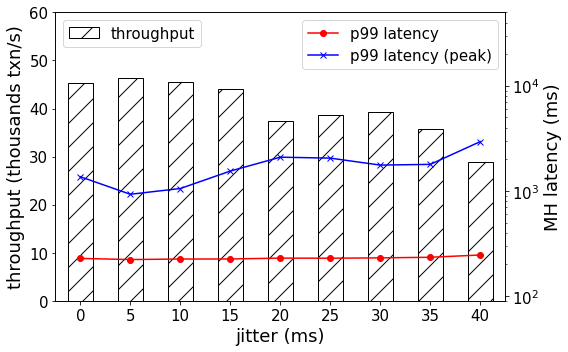

In [68]:
_, ax = plt.subplots(1, 1, figsize=(8, 5))

throughput_df.plot.bar(ax=ax, x="jitter", y="throughput", rot=0, fill=False, hatch='/')
ax.set_ylabel("throughput (thousands txn/s)")
ax.set_xlabel("jitter (ms)")
ax.set_ylim((0, 60))
ax.legend(loc="upper left")
ax2 = ax.twinx()

latency_200_df = latency_df[latency_df['clients'] == 200]
latency_3000_df = latency_df[latency_df['clients'] == 3000]

# latency_200_df.plot(ax=ax2, x="jitter", y="p50", label='p50 latency', linestyle='dotted', marker='.', color="red")
latency_200_df.plot(ax=ax2, x="jitter", y="p99", label='p99 latency', marker='o', color="red")
# latency_3000_df.plot(ax=ax2, x="jitter", y="p50", label='p50 latency', linestyle='dotted', marker='x', color="blue")
latency_3000_df.plot(ax=ax2, x="jitter", y="p99", label='p99 latency (peak)', marker='x', color="blue")
ax2.set_ylabel("MH latency (ms)")
ax2.set_yscale('log')
ax2.set_ylim((90, 50000))
ax2.legend(loc="upper right", ncol=1)
 
plt.tight_layout()
plt.savefig("output/jitter.pdf")

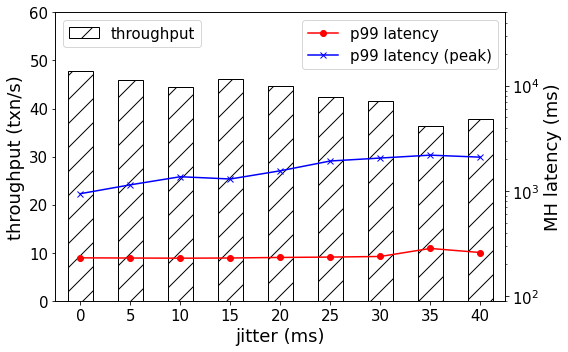

In [69]:
_, ax = plt.subplots(1, 1, figsize=(8, 5))

throughput_overshoot10_df.plot.bar(ax=ax, x="jitter", y="throughput", rot=0, fill=False, hatch='/')
ax.set_ylabel("throughput (txn/s)")
ax.set_xlabel("jitter (ms)")
ax.set_ylim((0, 60))
ax.legend(loc="upper left")
ax2 = ax.twinx()

latency_200_df = latency_overshoot10_df[latency_overshoot10_df['clients'] == 200]
latency_3000_df = latency_overshoot10_df[latency_overshoot10_df['clients'] == 3000]

# latency_200_df.plot(ax=ax2, x="jitter", y="p50", label='p50 latency', linestyle='dotted', marker='.', color="red")
latency_200_df.plot(ax=ax2, x="jitter", y="p99", label='p99 latency', marker='o', color="red")
# latency_3000_df.plot(ax=ax2, x="jitter", y="p50", label='p50 latency', linestyle='dotted', marker='x', color="blue")
latency_3000_df.plot(ax=ax2, x="jitter", y="p99", label='p99 latency (peak)', marker='x', color="blue")
ax2.set_ylabel("MH latency (ms)")
ax2.set_yscale('log')
ax2.set_ylim((90, 50000))
ax2.legend(loc="upper right", ncol=1)
 
plt.tight_layout()
plt.savefig("output/jitter-overshoot10.pdf")